In [5]:

# Load Datast

import pandas as pd
import numpy as np

df = pd.read_csv("E:\\J P Morgan Quantitative Research\\Task 3 and 4_Loan_Data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [13]:
df['default'].value_counts()

default
0    8149
1    1851
Name: count, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split the data into feature and target
X = df.drop(['default'], axis = 1)
y = df['default']

# scale the feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.2,
    stratify = y,
    random_state=42
)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# initiating and the logistic regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# for the robustness
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

C:\Users\Ahmad Reza\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier()

In [30]:
# Predicting Probability of default (PD)
pd_log = log_model.predict_proba(X_test)[:, 1]
pd_rf = rf_model.predict_proba(X_test)[:, 1]

In [34]:
print("Logistic Regression PD Predictions:")
print(pd_log[:10])  # Show first 10 probabilities

print("\nRandom Forest PD Predictions:")
print(pd_rf[:10])

# Interpretation:
# Observation 8 shows a very high predicted probability of default in both models (≈1.0),
# while others show very low risk. This suggests high model agreement on extreme cases.

Logistic Regression PD Predictions:
[9.70685419e-09 1.68367386e-03 6.81636092e-09 2.50943125e-08
 8.36536565e-06 1.81803615e-03 3.07661316e-06 9.99927615e-01
 9.37197572e-08 7.61985043e-12]

Random Forest PD Predictions:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


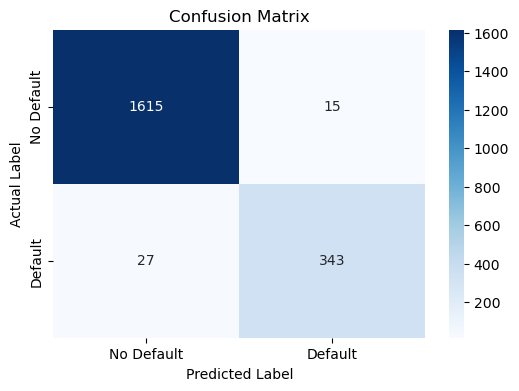

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class labels
y_pred = log_model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()


In [48]:
from sklearn.metrics import classification_report, roc_auc_score

# Assuming you have y_test and y_pred already
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))


Classification Report:

              precision    recall  f1-score   support

  No Default       0.98      0.99      0.99      1630
     Default       0.96      0.93      0.94       370

    accuracy                           0.98      2000
   macro avg       0.97      0.96      0.96      2000
weighted avg       0.98      0.98      0.98      2000



ROC-AUC Score: 0.9979


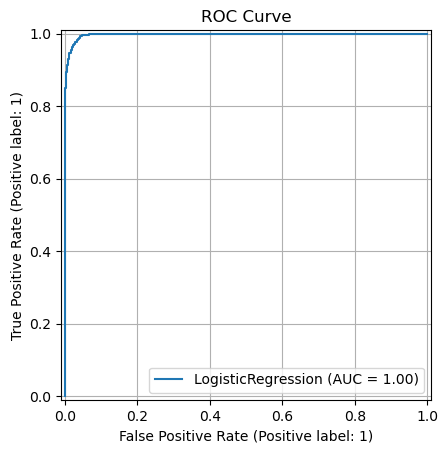

In [61]:
# Get predicted probabilities (for the positive class)
y_prob = log_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(log_model, X_test, y_test)
plt.title("ROC Curve")
plt.grid(True)
plt.show()


## Model Evaluation Summary

The classification report and ROC-AUC score indicate that the model performs exceptionally well in predicting borrower defaults:

- Precision (Default = 1): 0.96  
- Recall (Default = 1): 0.93  
- F1-Score (Default = 1): 0.94  
- Overall Accuracy: 98%  
- ROC-AUC Score: 0.9979

These metrics show that the model achieves a strong balance between identifying defaulters (recall) and minimizing false alarms (precision). A near-perfect ROC-AUC suggests excellent class separation capability.

>  Based on this robust performance, we can now reliably use the model's predicted probabilities (PD) to estimate the Expected Loss (EL) for each borrower using the formula:
> Expected Loss = PD * Exposure at Default (EAD) * (1 - Recovery Rate)


In [75]:
def expected_loss(pd, ead, recovery_rate=0.10):
    """
    Calculate expected loss for a borrower.

    Parameters:
    - pd: float, probability of default (0 to 1)
    - ead: float, exposure at default (loan amount)
    - recovery_rate: float, expected recovery rate (default is 10%)

    Returns:
    - float: expected loss value
    """
    lgd = 1 - recovery_rate  # Loss Given Default
    return round(pd * ead * lgd, 2)

In [77]:
# Example borrower
pd_value = 0.42              # predicted PD
ead_value = 100000           # loan amount in ₹

loss = expected_loss(pd_value, ead_value)
print(f"Expected Loss: ₹{loss}")


Expected Loss: ₹37800.0
